In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import pymc3 as pm
import arviz as az
import pandas as pd
import scipy.linalg as l
import seaborn as sns
print('Running on PyMC3 v{}'.format(pm.__version__))
import theano
from sklearn.model_selection import train_test_split
import shelve
import warnings

%matplotlib inline
sns.set()
warnings.filterwarnings('ignore')

Running on PyMC3 v3.9.3


In [2]:
# 1 load the data sets
pr_file   = "/home/hyung/Lab/data/DL_Error/predictors.csv"
res_file  = "/home/hyung/Lab/data/DL_Error/responses.csv"
pr_data   = pd.read_csv(pr_file)
res_data  = pd.read_csv(res_file)

# Rainf_f/Precip/SWdown_min have some issue because they are all zeros
pr_data.drop(columns=['Rainf_min', 'Rainf_f_min', 'Rainf_f_max','Rainf_f_tavg', 'TotalPrecip_min'], inplace=True)
pr_data.drop(columns=['Evap_min', 'Evap_max', 'Evap_tavg'], inplace=True)
pr_data.drop(columns=['LWdown_f_max', 'LWdown_f_min', 'LWdown_f_tavg'], inplace=True)
pr_data.drop(columns=['Qair_f_max',	'Qair_f_min', 'Qh_max',	'Qh_min'], inplace=True)
pr_data.drop(columns=['Qle_min', 'Qle_max', 'Qle_tavg'], inplace=True)
pr_data.drop(columns=['SWdown_f_min', 'SWdown_f_max', 'SWdown_f_tavg'], inplace=True)
pr_data.drop(columns=['SMOS_RFI_min', 'SoilMoist_max', 'SoilMoist_min',	'SoilMoist_tavg'], inplace=True)
pr_data.drop(columns=['Tair_f_max', 'Tair_f_min', 'Tair_f_tavg', 'aspect'], inplace=True)
pr_data.drop(columns=['Wind_f_max',	'Wind_f_min', 'Wind_f_tavg'], inplace=True)

In [3]:
# TC estimations with std value larger than 0.2 might be unstable
std_thred     = 0.1
mask_std_A2   = res_data['AMSR2_std'] <= std_thred
mask_std_AS   = res_data['ASCAT_std'] <= std_thred
mask_std_SMOS = res_data['SMOS_std'] <= std_thred
mask_std_SMAP = res_data['SMAP_std'] <= std_thred

In [162]:
# 2 clean the data sets
selected_predictors = list(pr_data.columns.values)

sel_A2   = selected_predictors.copy()
sel_A2.append('AMSR2_fMSE')
sel_AS   = selected_predictors.copy()
sel_AS.append('ASCAT_fMSE')
sel_SMOS = selected_predictors.copy()
sel_SMOS.append('SMOS_fMSE')
sel_SMAP = selected_predictors.copy()
sel_SMAP.append('SMAP_fMSE')

A2_fMSE   = pr_data.join(res_data['AMSR2_fMSE'])[sel_A2]
AS_fMSE   = pr_data.join(res_data['ASCAT_fMSE'])[sel_AS]
SMOS_fMSE = pr_data.join(res_data['SMOS_fMSE'])[sel_SMOS]
SMAP_fMSE = pr_data.join(res_data['SMAP_fMSE'])[sel_SMAP]

# select fMSE <= threshold
A2_fMSE   = A2_fMSE[mask_std_A2]
AS_fMSE   = AS_fMSE[mask_std_AS]
SMOS_fMSE = SMOS_fMSE[mask_std_SMOS]
SMAP_fMSE = SMAP_fMSE[mask_std_SMAP]
                      
# drop N/A
A2_fMSE.dropna(axis=0, how='any', inplace=True)
AS_fMSE.dropna(axis=0, how='any', inplace=True)
SMOS_fMSE.dropna(axis=0, how='any', inplace=True)
SMAP_fMSE.dropna(axis=0, how='any', inplace=True)

# Numeric, categorical predictors and response, y`
# AMSR2
A2_num   = A2_fMSE.drop(columns=['ltype', 'AMSR2_fMSE'])
A2_cat   = A2_fMSE['ltype']
A2_y     = A2_fMSE['AMSR2_fMSE']
# ASCAT
AS_num   = AS_fMSE.drop(columns=['ltype', 'ASCAT_fMSE'])
AS_cat   = AS_fMSE['ltype']
AS_y     = AS_fMSE['ASCAT_fMSE']
# SMOS
SMOS_num = SMOS_fMSE.drop(columns=['ltype', 'SMOS_fMSE'])
SMOS_cat = SMOS_fMSE['ltype']
SMOS_y   = SMOS_fMSE['SMOS_fMSE']
# SMAP
SMAP_num = SMAP_fMSE.drop(columns=['ltype', 'SMAP_fMSE'])
SMAP_cat = SMAP_fMSE['ltype']
SMAP_y   = SMAP_fMSE['SMAP_fMSE']

all_predictors = SMAP_num.columns.values

# Standardize numeric/response columns, to mean 0 variance 1
# AMSR2
A2_mean       = A2_num.mean()
A2_std        = A2_num.std()
A2_num_scaled = np.array((A2_num - A2_mean) / A2_std)
A2_y_mean     = A2_y.mean()
A2_y_std      = A2_y.std()
A2_y_scaled   = np.array((A2_y - A2_y_mean) / A2_y_std)
# ASCAT
AS_mean       = AS_num.mean()
AS_std        = AS_num.std()
AS_num_scaled = np.array((AS_num - AS_mean) / AS_std)
AS_y_mean     = AS_y.mean()
AS_y_std      = AS_y.std()
AS_y_scaled   = np.array((AS_y - AS_y_mean) / AS_y_std)
# SMOS
SMOS_mean       = SMOS_num.mean()
SMOS_std        = SMOS_num.std()
SMOS_num_scaled = np.array((SMOS_num - SMOS_mean) / SMOS_std)
SMOS_y_mean     = SMOS_y.mean()
SMOS_y_std      = SMOS_y.std()
SMOS_y_scaled   = np.array((SMOS_y - SMOS_y_mean) / SMOS_y_std)
# SMAP
SMAP_mean        = SMAP_num.mean()
SMAP_std         = SMAP_num.std()
SMAP_num_scaled  = np.array((SMAP_num - SMAP_mean) / SMAP_std)
SMAP_y_mean      = SMAP_y.mean()
SMAP_y_std       = SMAP_y.std()
SMAP_y_scaled    = np.array((SMAP_y - SMAP_y_mean) / SMAP_y_std)

# SKIP cat var for this time
A2_X   = A2_num
AS_X   = AS_num
SMOS_X = SMOS_num
SMAP_X = SMAP_num

# No. of predictors
A2_k   = A2_X.shape[1]
AS_k   = AS_X.shape[1]
SMOS_k = SMOS_X.shape[1]
SMAP_k = SMAP_X.shape[1]

In [ ]:
#define function

def nuts_advi(X_scaled, y_scaled, k, ofp, type = 'nuts'):
    X_train, X_test, y_train, y_test = train_test_split(A2_num_scaled, A2_y_scaled, test_size=0.33, random_state=42)
    y_tensor = theano.shared(y_train.astype('float64'))
    X_tensor = theano.shared(X_train.astype('float64'))

    with pm.Model() as base_model:

        # Gumbel distribution 
        # Intercept term
        β0 = pm.Normal('β0', mu=0, sd=1e5)

        # Beta coefficients for predictor variables
        β = pm.MvNormal('β', mu=np.zeros(k), cov=np.eye(k), shape=k)

        # Calcuate mean from the normal variables, and add intercept
        mu = pm.math.dot(X_tensor,β) + β0
        beta = pm.HalfCauchy('beta', 1e5)

        # Pass the mu and beta with the observed data
        y_likelihood = pm.Gumbel('fMSE', mu=mu, beta=beta, observed=y_tensor)

        #start = pm.find_MAP()

    #pm.model_to_graphviz(base_model)
    
    if type == 'nuts':
        with base_model:
        # Variational inference with ADVI optimization
        step       = pm.NUTS(target_accept=0.95)
        trace_nuts = pm.sample(draws=2000, step=step, tune=1000, cores=4)
        idata_nuts = az.from_pymc3(trace_nuts)
    
        filename = ofp + '_nuts.out'
        my_shelf = shelve.open(filename, 'n')
        #my_shelf['base_model']     = globals()['base_model']
        my_shelf['trace_nuts'] = globals()['trace_nuts']
        my_shelf['idata_nuts'] = globals()['idata_nuts']
        my_shelf['X_tensor']   = globals()['X_tensor']
        my_shelf['y_tensor']   = globals()['y_tensor']
        my_shelf['X_train']    = globals()['X_train']
        my_shelf['y_train']    = globals()['y_train']
        my_shelf['X_test']     = globals()['X_test']
        my_shelf['y_test']     = globals()['y_test']
        my_shelf.close()
        
    if type == 'advi'
        map_tensor_batch = {y_tensor: pm.Minibatch(y_train, 5000), X_tensor: pm.Minibatch(X_train, 5000)}
        
        with base_model:
             fit_advi= pm.fit(method=pm.ADVI(), n=100000, more_replacements = map_tensor_batch)
        
        trace_advi = fit_advi.sample(10000)
       
        filename = ofp + '_advi.out'
        my_shelf = shelve.open(filename, 'n')
        #my_shelf['base_model']     = globals()['base_model']
        my_shelf['fit_advi']   = globals()['fit_advi']
        my_shelf['trace_advi'] = globals()['trace_advi']
        my_shelf['X_tensor']   = globals()['X_tensor']
        my_shelf['y_tensor']   = globals()['y_tensor']
        my_shelf['X_train']    = globals()['X_train']
        my_shelf['y_train']    = globals()['y_train']
        my_shelf['X_test']     = globals()['X_test']
        my_shelf['y_test']     = globals()['y_test']
        my_shelf.close()

In [163]:
#SMAP_X_df        = pd.DataFrame(SMAP_X, columns = all_predictors)
#SMAP_y_scaled_df = pd.DataFrame(SMAP_y_scaled, columns = ['y'])

#X_train, X_test, y_train, y_test = train_test_split(SMAP_num_scaled, SMAP_y_scaled, test_size=0.33, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(A2_num_scaled, A2_y_scaled, test_size=0.33, random_state=42)

y_tensor = theano.shared(y_train.astype('float64'))
X_tensor = theano.shared(X_train.astype('float64'))

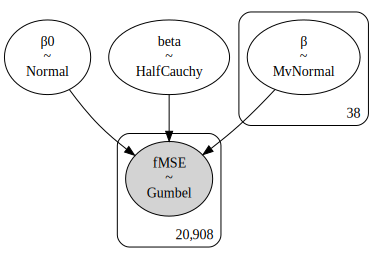

In [164]:
# 4 Sampling method 
# Show the graphical representation
#X = SMAP_num_scaled[:,[7,21,25]]

#X = X_tensor
#y = y_tensor
k = SMAP_k

with pm.Model() as base_model:
    
    #X = pm.Data('X', X_train)
    #y = pm.Data('y', y_train)
    
    # Gumbel distribution 
    # Intercept term
    β0 = pm.Normal('β0', mu=0, sd=1e5)
    
    # Beta coefficients for predictor variables
    β = pm.MvNormal('β', mu=np.zeros(k), cov=np.eye(k), shape=k)
    
    # Calcuate mean from the normal variables, and add intercept
    mu = pm.math.dot(X_tensor,β) + β0
    beta = pm.HalfCauchy('beta', 1e5)
    
    # Pass the mu and beta with the observed data
    y_likelihood = pm.Gumbel('fMSE', mu=mu, beta=beta, observed=y_tensor)
    
    #start = pm.find_MAP()
    
pm.model_to_graphviz(base_model)

In [166]:
with base_model:
    # Variational inference with ADVI optimization
    step           = pm.NUTS(target_accept=0.95)
    trace_sampling = pm.sample(draws=2000, step=step, tune=1000, cores=4)
    idata_sampling = az.from_pymc3(trace_sampling)
    
#az.summary(idata_sampling, round_to=2, var_names = ['β'])
# plot the ELBO vs. fitting time or iterations (n)
ofp = '/home/hyung/Lab/libs/python/DL_Error/AMSR2'
filename = ofp + '_sampling.out'
my_shelf = shelve.open(filename, 'n')
#my_shelf['base_model']     = globals()['base_model']
my_shelf['trace_sampling'] = globals()['trace_sampling']
my_shelf['idata_sampling'] = globals()['idata_sampling']
my_shelf.close()

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, β, β0]


Sampling 4 chains for 1_000 tune and 1_691 draw iterations (4_000 + 6_764 draws total) took 8280 seconds.


In [106]:
ofp = '/home/hyung/Lab/libs/python/DL_Error/SMAP' 
filename = ofp + '_sampling.out'
my_shelf = shelve.open(filename, 'n')
#my_shelf['base_model']     = globals()['base_model']
my_shelf['trace_sampling'] = globals()['trace_sampling']
my_shelf['idata_sampling'] = globals()['idata_sampling']
my_shelf.close()

In [107]:
pm.summary(trace_sampling)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
β0,-0.389,0.005,-0.398,-0.380,0.000,0.000,11967.0,11967.0,11961.0,6531.0,1.0
β[0],1.144,0.097,0.958,1.322,0.001,0.001,6168.0,6127.0,6183.0,5792.0,1.0
β[1],-0.109,0.201,-0.485,0.263,0.003,0.002,5949.0,4812.0,5955.0,5818.0,1.0
β[2],0.251,0.413,-0.524,1.017,0.005,0.004,5664.0,4532.0,5668.0,5240.0,1.0
β[3],0.001,0.006,-0.009,0.012,0.000,0.000,11402.0,3787.0,11414.0,6037.0,1.0
β[4],-0.008,0.094,-0.176,0.179,0.001,0.001,6203.0,4186.0,6218.0,5445.0,1.0
β[5],0.011,0.017,-0.022,0.043,0.000,0.000,7669.0,5956.0,7663.0,6029.0,1.0
β[6],-0.076,0.099,-0.265,0.111,0.001,0.001,6075.0,5246.0,6094.0,5293.0,1.0
β[7],-0.154,0.029,-0.207,-0.098,0.000,0.000,4800.0,4676.0,4814.0,4800.0,1.0
β[8],-0.248,0.038,-0.318,-0.175,0.001,0.000,4593.0,4534.0,4597.0,4780.0,1.0


array([[<AxesSubplot:title={'center':'β0'}>,
        <AxesSubplot:title={'center':'β0'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

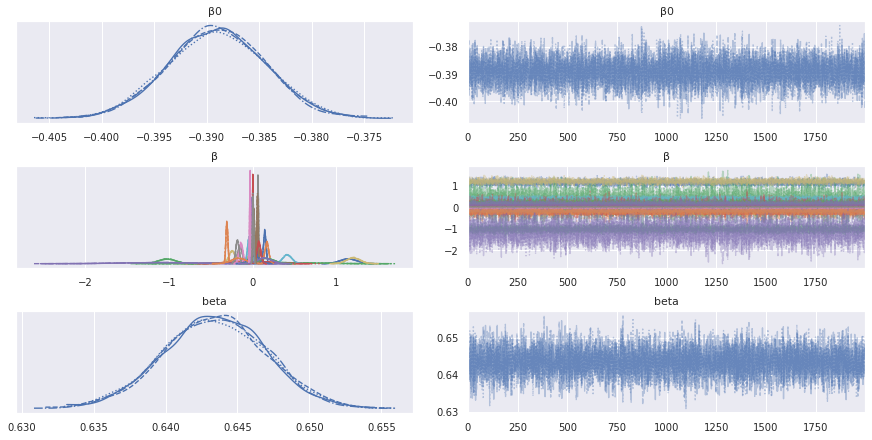

In [108]:
pm.traceplot(trace_sampling)

In [146]:
map_tensor_batch = {y_tensor: pm.Minibatch(y_train, 5000),
                    X_tensor: pm.Minibatch(X_train, 5000)
                   }

In [147]:
with base_model:
     advi_fit = pm.fit(method=pm.ADVI(), n=100000,
                      more_replacements=map_tensor_batch)

Finished [100%]: Average Loss = 6,506.2


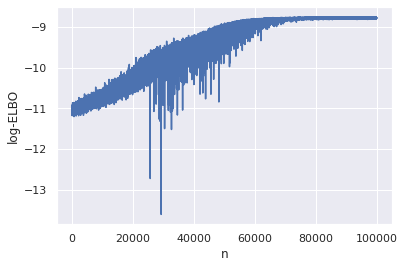

In [148]:
advi_elbo = pd.DataFrame(
    {'log-ELBO': -np.log(advi_fit.hist),
     'n': np.arange(advi_fit.hist.shape[0])})

_ = sns.lineplot(y='log-ELBO', x='n', data=advi_elbo)

In [149]:
advi_trace = advi_fit.sample(10000)
pm.summary(advi_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
β0,-0.407,0.012,-0.430,-0.384,0.0,0.0,9994.0,9994.0,9988.0,9779.0,NaN
β[0],0.893,0.013,0.869,0.916,0.0,0.0,10091.0,10091.0,10095.0,9985.0,NaN
β[1],0.239,0.012,0.216,0.262,0.0,0.0,9981.0,9980.0,9980.0,9767.0,NaN
β[2],0.239,0.013,0.214,0.264,0.0,0.0,9941.0,9938.0,9944.0,9928.0,NaN
β[3],0.065,0.012,0.043,0.089,0.0,0.0,10379.0,10379.0,10373.0,9481.0,NaN
β[4],-0.424,0.013,-0.449,-0.401,0.0,0.0,9995.0,9994.0,10002.0,9033.0,NaN
β[5],0.177,0.013,0.153,0.201,0.0,0.0,10086.0,10052.0,10081.0,10138.0,NaN
β[6],-0.134,0.013,-0.158,-0.109,0.0,0.0,10093.0,10093.0,10092.0,9971.0,NaN
β[7],-0.110,0.013,-0.134,-0.087,0.0,0.0,10095.0,10068.0,10091.0,9682.0,NaN
β[8],-0.172,0.012,-0.194,-0.149,0.0,0.0,9499.0,9498.0,9499.0,9680.0,NaN


array([[<AxesSubplot:title={'center':'β0'}>,
        <AxesSubplot:title={'center':'β0'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

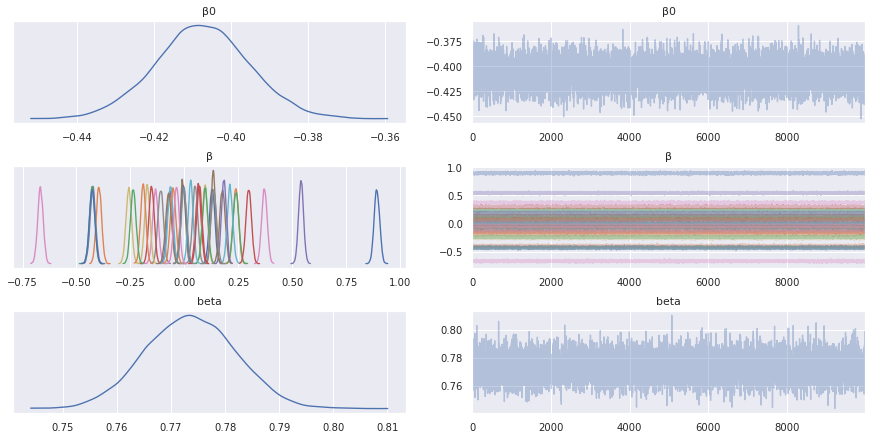

In [150]:
pm.traceplot(advi_trace)

In [114]:
y_tensor.set_value(y_test)
X_tensor.set_value(X_test)

In [118]:
nuts_predictions.shape

(10447,)

In [119]:
#with base_model:
#    nuts_posterior_pred = pm.fast_sample_posterior_predictive(trace_sampling)
#    nuts_predictions    = np.mean(nuts_posterior_pred['fMSE'], axis=0) 

nuts_posterior_pred = pm.fast_sample_posterior_predictive(trace_sampling, model=base_model)
nuts_predictions = np.mean(nuts_posterior_pred['fMSE'], axis=0)

advi_posterior_pred = pm.fast_sample_posterior_predictive(advi_trace, model=base_model)
advi_predictions = np.mean(advi_posterior_pred['fMSE'], axis=0)

<AxesSubplot:xlabel='fMSE'>

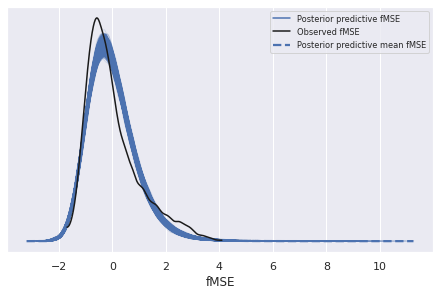

In [120]:
az.plot_ppc(az.from_pymc3(posterior_predictive=nuts_posterior_pred, model=base_model))

<AxesSubplot:xlabel='fMSE'>

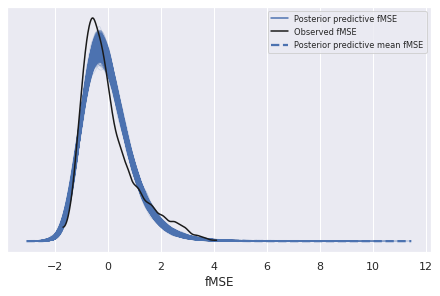

In [121]:
az.plot_ppc(az.from_pymc3(posterior_predictive=advi_posterior_pred, model=base_model))

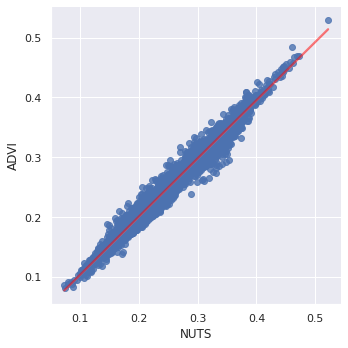

In [138]:
prediction_data = pd.DataFrame(
    {'NUTS': nuts_predictions*SMAP_y_std + SMAP_y_mean, 
     'ADVI': advi_predictions*SMAP_y_std + SMAP_y_mean, 
     'actual': y_test*SMAP_y_std + SMAP_y_mean,
     'error_NUTS': (nuts_predictions - y_test)*SMAP_y_std + SMAP_y_mean,
     'error_ADVI': (advi_predictions - y_test)*SMAP_y_std + SMAP_y_mean})

_ = sns.lmplot(y='ADVI', x='NUTS', data = prediction_data,
               line_kws={'color': 'red', 'alpha': 0.5})

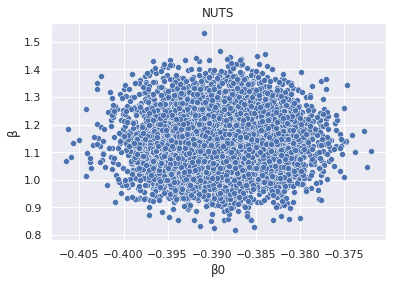

In [139]:
param_samples_NUTS = pd.DataFrame(
    {'β0': trace_sampling.get_values('β0')[:, ], 
     'β': trace_sampling.get_values('β')[:, 0]})

_ = sns.scatterplot(x='β0', y='β', data=param_samples_NUTS).set_title('NUTS')

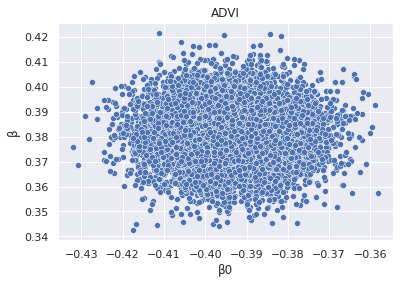

In [140]:
param_samples_ADVI = pd.DataFrame(
    {'β0': advi_trace.get_values('β0')[:, ], 
     'β': advi_trace.get_values('β')[:, 0]})

_ = sns.scatterplot(x='β0', y='β', data=param_samples_ADVI).set_title('ADVI')

RMSE for ADVI predictions = 0.271


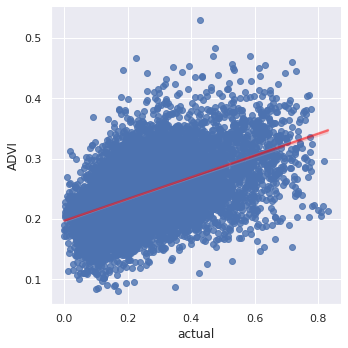

In [143]:
RMSE = np.sqrt(np.mean(prediction_data.error_ADVI ** 2))

print(f'RMSE for ADVI predictions = {RMSE:.3f}')

_ = sns.lmplot(y='ADVI', x='actual', data=prediction_data, 
               line_kws={'color': 'red', 'alpha': 0.5})

Finished [100%]: Average Loss = 36,916


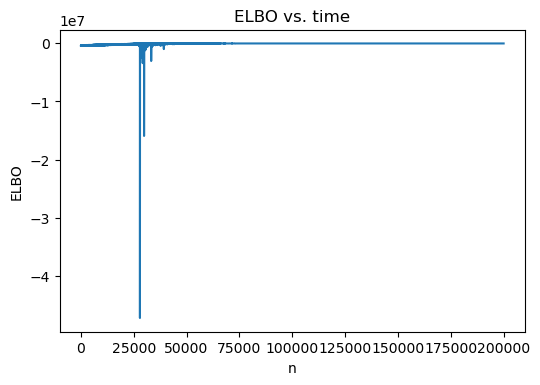

In [103]:
# Variational inference with ADVI optimization
with base_model:
     advi_fit = pm.fit(100000, method='advi')

advi_elbo = pd.DataFrame(
    {'ELBO': -advi_fit_test.hist,
     'n': np.arange(advi_fit.hist.shape[0])})

plt.figure(dpi=100)
ax = sns.lineplot(y='ELBO', x='n', data=advi_elbo)
ax.set_title("ELBO vs. time")
plt.show()

/home/hyung/anaconda3/envs/pm3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
arviz - WARNING - Shape validation failed: input_shape: (1, 20000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
β[0],1.2159,0.0042,1.2079,1.2237,0.0,0.0,20499.9171,20498.6718,20507.8532,20046.4237,NaN
β[1],-0.0424,0.0041,-0.0502,-0.0350,0.0,0.0,19613.8226,19568.8663,19610.2359,19589.2787,NaN
β[2],-0.2017,0.0041,-0.2093,-0.1939,0.0,0.0,19761.9390,19760.0784,19843.7792,19355.1269,NaN
β[3],0.0006,0.0040,-0.0072,0.0080,0.0,0.0,20012.8574,20012.8574,20012.9573,19734.7837,NaN
β[4],-0.1725,0.0041,-0.1803,-0.1648,0.0,0.0,20273.3114,20260.8386,20276.6582,20216.2028,NaN
β[5],-0.0068,0.0041,-0.0146,0.0009,0.0,0.0,19917.6988,19549.7037,19918.9706,19549.1934,NaN
β[6],0.1004,0.0042,0.0926,0.1083,0.0,0.0,20075.1945,20046.5396,20080.8684,19156.9440,NaN
β[7],-0.1434,0.0041,-0.1512,-0.1358,0.0,0.0,19599.6147,19599.6147,19593.5996,19714.5737,NaN
β[8],-0.2513,0.0039,-0.2585,-0.2437,0.0,0.0,18626.4950,18611.8281,18639.1614,19318.4130,NaN
β[9],0.4139,0.0040,0.4063,0.4212,0.0,0.0,19783.5218,19783.5218,19778.4058,18640.8712,NaN


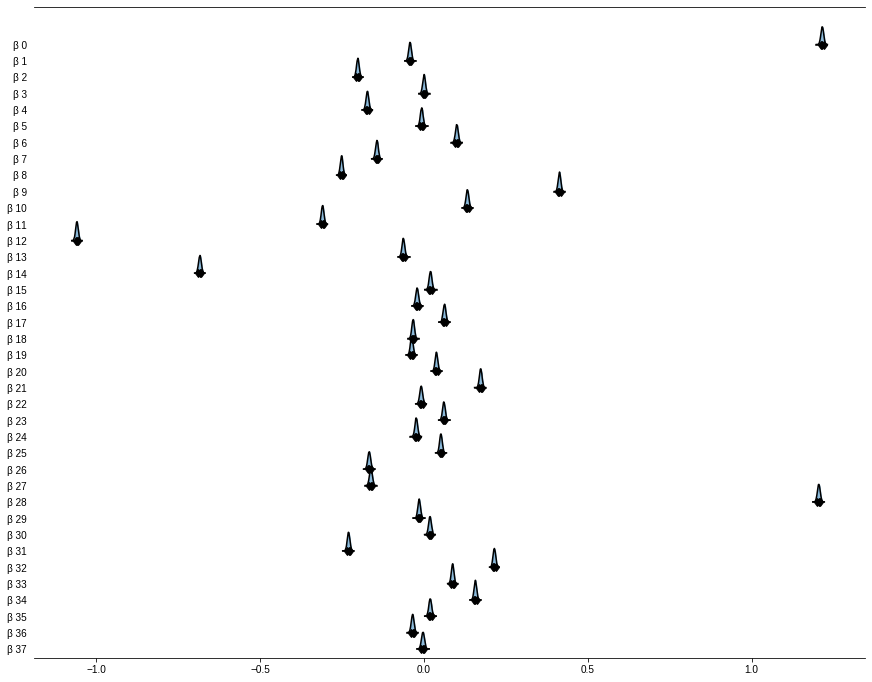

In [123]:
PPC_SAMPLES = 20000
advi_trace  = advi_fit.sample(PPC_SAMPLES)

# Forest Plots to show the distributions for each of the predictors
#with advi_model:
az.plot_forest(advi_trace, var_names=['β'], combined=True,
               kind='ridgeplot', ridgeplot_quantiles=[0.16, 0.5, 0.84],
               ridgeplot_truncate=False, hdi_prob=0.95,
               ridgeplot_overlap=3, ridgeplot_alpha=0.5)

with base_model:
    idata_advi = az.from_pymc3(advi_trace)
az.summary(idata_advi, round_to=4, var_names = ['β'])

In [115]:
all_predictors

array(['AvgSurfT_max', 'AvgSurfT_min', 'AvgSurfT_tavg', 'GINI_36',
       'Greenness_max', 'Greenness_min', 'Greenness_tavg', 'LAI_max',
       'LAI_min', 'LAI_tavg', 'Qair_f_tavg', 'Qh_tavg', 'RadT_max',
       'RadT_min', 'RadT_tavg', 'Rainf_max', 'Rainf_tavg', 'SAND',
       'SMAP_rc_max', 'SMAP_rc_min', 'SMAP_rc_tavg', 'SMAP_vo_max',
       'SMAP_vo_min', 'SMAP_vo_tavg', 'SMOS_RFI_max', 'SMOS_RFI_tavg',
       'SoilTemp_max', 'SoilTemp_min', 'SoilTemp_tavg', 'TotalPrecip_max',
       'TotalPrecip_tavg', 'albedo_max', 'albedo_min', 'albedo_std',
       'albedo_tavg', 'elevation', 'irrfrac', 'slope'], dtype=object)

In [124]:
np.where(all_predictors == 'RadT_max')

(array([12]),)

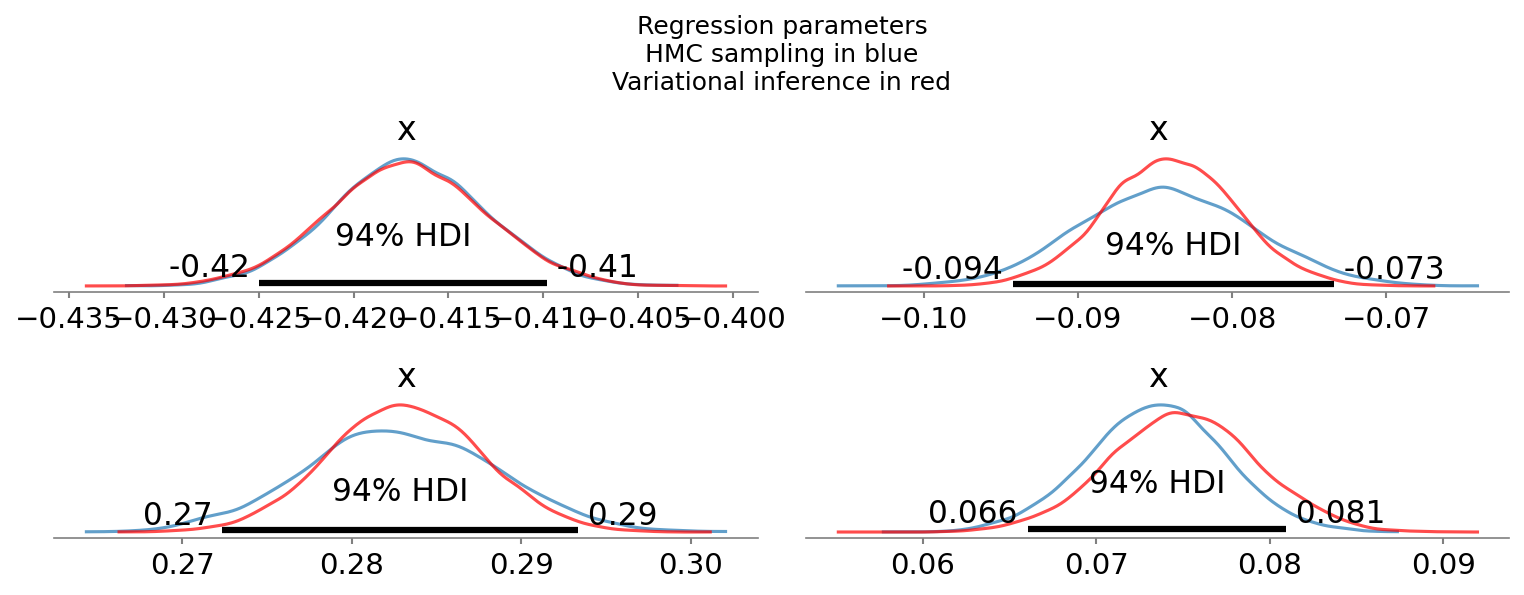

In [95]:
burnin = 100
sample_intercept = test_trace['β0'][burnin:]
sample_betas = test_trace['β'][burnin:]
advi_intercept = advi_trace_test['β0']
advi_betas = advi_trace_test['β']

# Plot posteriors

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 4), dpi=150, constrained_layout=False)

for ax, estimate_sampling, estimate_advi in zip(axes.ravel(),
                               [sample_intercept] + [sample_betas[:,i] for i in range(k)],
                               [advi_intercept] + [advi_betas[:,i] for i in range(k)]):
    
    pm.plot_posterior(estimate_sampling, ax=ax,point_estimate=None,  alpha=0.7)
    pm.plot_posterior(estimate_advi, ax=ax, color='red', point_estimate=None, hdi_prob= 'hide', alpha=0.7)
    
    #ax.set_title(title, fontsize=12)

    #ax.set_xlabel(xlabel, fontsize=12)

plt.suptitle("Regression parameters\nHMC sampling in blue\nVariational inference in red")
plt.tight_layout()
plt.subplots_adjust(top=0.75)
plt.show()

In [ ]:
y_tensor = theano.shared(y.astype('float64'))
x_tensor = theano.shared(X.astype('float64'))
#train, test = train_test_split(model_data, test_size=0.2)
map_tensor_batch = {y_tensor: pm.Minibatch(y, 100),
                    x_tensor: pm.Minibatch(X, 100)}

with advi_model:
    advi_fit2 = pm.fit(method='advi', n=200000, more_replacements=map_tensor_batch)

#y_tensor = theano.shared(train#

In [ ]:
# sample from the variational posterior distribution
PPC_SAMPLES = 20000
advi_trace = advi_fit.sample(PPC_SAMPLES)

# Forest Plots to show the distributions for each of the predictors
#with advi_model:
    #pm.forestplot(advi_trace, var_names=['β'])

az.plot_forest(advi_trace, var_names=['β'], combined=True,
               kind='ridgeplot', ridgeplot_quantiles=[0.16, 0.5, 0.84],
               ridgeplot_truncate=False, hdi_prob=0.95,
               ridgeplot_overlap=3, ridgeplot_alpha=0.5)

with advi_model:
    hierarchical_idata = az.from_pymc3(advi_trace)
az.summary(hierarchical_idata, round_to=4, var_names = ['β'])

In [ ]:
all_predictors[37]

In [ ]:
# Get the sampling results for comparison
with pm.Model() as sampling_model: 
    
     # Intercept term
    β0 = pm.Normal('β0', mu=0, sd=1e5)
    
    # Beta coefficients for predictor variables
    β = pm.MvNormal('β', mu=np.zeros(k), cov=np.eye(k), shape=k)
    
    # Calculate logit from the normal variables, and add itercept
    #logit = pm.math.dot(A2_X,β) + β0
    mu = pm.math.dot(X,β) + β0
    sigma = pm.HalfCauchy('beta', 1e5)    
    #sigma = pm.Normal('sigma', mu=0, sd=100)
    #sigma = 1
    # Pass the logits to a Bernoulli outcome, with the observed data
    #y_pred = pm.Bernoulli('AMSR2_fMSE', logit_p=logit, observed=A2_y)

    #y_pred = pm.Normal('fMSE', mu=alpha, sigma=beta, observed=y)
    #y_pred = pm.TruncatedNormal('fMSE', mu=mu, sigma=sigma, observed=y, lower=0, upper=1)
    #y_pred = pm.Kumaraswamy('fMSE', a=mu, b=sigma, observed=y)
    #y_pred = pm.Gamma('fMSE', alpha=alpha, beta=beta, observed=y) 
    
    # Sample
    #trace = pm.sample(draws=1000, step=pm.NUTS(target_accept=0.99), tune=5000)
    start = pm.find_MAP()
    
    #trace_main = pm.sample(10000, cores=4)
    
pm.model_to_graphviz(sampling_model)

In [ ]:
with sampling_model:
     step = pm.NUTS(target_accept=0.95)
     #trace = pm.sample(draws=2000, start=start, step=step, tune=1000)
     trace = pm.sample(draws=2000, step=step, tune=1000)

In [ ]:
with sampling_model:
    sampling_idata = az.from_pymc3(trace)
az.summary(sampling_idata, round_to=2, var_names = ['β'])

In [ ]:
# Trace plots
with sampling_model:
    az.plot_trace(trace, var_names=['β0','β'])

In [ ]:
burnin = 100
intercept = trace['β0'][burnin:]
beta = trace['β'][burnin:]
std = A2_std
mean = A2_mean
#for i in range(k-1):
#    beta[:, i] = beta[:, i] * std[i] + mean[i]

# Plot posteriors
fig, axes = plt.subplots(11,4, figsize=(8,60), dpi=150)

for ax, estimate, title, xlabel in zip(fig.axes,
                               [intercept] + [beta[:,i] for i in range(k)],
                               all_predictors,
                               all_predictors):
    pm.plot_posterior(estimate, point_estimate='mode', ax=ax)
    ax.set_title(title, fontsize=6)
    #ax.set_xlabel(xlabel, fontsize=6)

#plt.tight_layout()

In [ ]:
np.percentile(trace['β'][0], 0.7)

In [ ]:
burnin = 100
sample_intercept = trace['β'][burnin:]
advi_intercept = advi_trace['β']
nlevels = k
levels = all_predictors
# Plot posteriors

fig, axes = plt.subplots(nrows=11, ncols=4, figsize=(12, 20), dpi=150)

for i, ax, level in zip(range(nlevels), axes.ravel(), levels):

    try:
        t_sample = sample_intercept[:,i]
        t_advi  = advi_intercept[:,i]
        p1 = np.percentile(t_sample, 1)
        p2 = np.percentile(t_sample, 99)
        p11 = np.percentile(t_advi, 1)
        p22 = np.percentile(t_advi, 99)
        lb = p1
        ub = p2
        if p11 < p1:
            lb = p11
        if p22 > p2:
            ub = p22
        #pm.plot_posterior(invlogit(sample_intercept[:, i]), ax=ax, point_estimate=None, credible_interval=None, alpha=0.7)
        #pm.plot_posterior(invlogit(advi_intercept[:, i]), ax=ax, color='red', point_estimate=None, credible_interval=None, alpha=0.7)
        axes2 = pm.plot_posterior(t_sample, ax=ax, point_estimate=None,  alpha=0.7, hdi_prob= 'hide')
        pm.plot_posterior(t_advi, ax=ax, color='red', point_estimate=None, hdi_prob= 'hide', alpha=0.7)
        axes2.set_xlim(lb,ub)
        ax.set_title(str(level), fontsize=12)
        #ax.set_xlabel("Contraception use", fontsize=12)
  
        #axes.set_xlim([p1,p2])
        
    except IndexError: # one district is empty
        pass
    

#plt.suptitle("Regression parameters\nHMC sampling in blue\nVariational inference in red")
plt.tight_layout()
plt.subplots_adjust(top=0.925)
plt.show()